<a href="https://colab.research.google.com/github/yoineko/skillfactory-module6/blob/master/fine_tuning_EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Это пример решения задачи с использованием модели EfficientNetB7. 
# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть EfficientNetB7 и применить Transfer learning & fine-tuning. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')
DIR = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!nvidia-smi

Mon Aug 24 20:16:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
from pathlib import Path


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB6, EfficientNetB7, EfficientNetB0
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K


from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir(DIR + "input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['sample-submission.csv', 'test.zip', 'train.csv', 'train.zip', 'train.gsheet', 'sample-submission.gsheet']
Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [5]:
!pip freeze > requirements.txt

# Основные настройки

In [6]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 7 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 600  #  какого размера подаем изображения в сеть  (# input shape expected resolution )
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

PATH = "../working/car/" # рабочая директория
DATA_PATH = DIR + 'input/'

ver = '7_21'

In [7]:
# Устаналиваем конкретное значение random seed для воспроизводимости
#os.makedirs(PATH,  exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [8]:
train_df = pd.read_csv(os.path.join(DATA_PATH,"train.csv"))
sample_submission = pd.read_csv(os.path.join(DATA_PATH,"sample-submission.csv"))

In [11]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DIR + "/input/"+data_zip,"r") as z:    
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


# Подготовка данных

### Аугментация данных

In [15]:
# Так как у нас небольшой датасет, то применем к нему аугментацию  данных.
train_datagen = ImageDataGenerator(
   # rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    )

test_datagen = ImageDataGenerator(
  #  rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    )

### Генерация данных

In [16]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, seed=RANDOM_SEED,
    subset='validation') # set as validation data

#test_sub_generator = test_datagen.flow_from_dataframe( 
test_sub_generator = train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# Построение модели

### Загружаем предобученную сеть Xception:

In [17]:
# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
 #   K.set_session(s)
    tf.compat.v1.keras.backend.set_session(s)

s = reset_tf_session()

In [18]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()

In [19]:
# Загружаем базовую модель, добавляем параметр drop_connect_rate=0.4, чтобы избежать сильного переобучения после первого этапа обучения
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape, drop_connect_rate=0.4)

258080768/258076736 [==============================] - 7s 0us/step


In [20]:
# Знакомимся со структурой сети 
base_model.summary()

In [21]:
# Устанавливаем новую "голову" (head)
base_model.training=False

x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(100, activation='relu')(x)
x= Dropout(0.2)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

base_model.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 713
This is the number of trainable layers after freezing the conv base: 4


## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

И EarlyStopping, чтобы не терять время на обучении, если нет улучшения в течение заданного количества эпох.

In [27]:
checkpoint = ModelCheckpoint(os.path.join(DIR, f'best_model/best_model{ver}.hdf5') , monitor = 'val_accuracy' , verbose = 1  , save_best_only = True, mode = 'max')
earlystop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]


In [29]:
# mode_train False - all layers frezee, True - all layers not frezee
def config_model(mode_train, l_r, ephochs,  fine_tune_at = 0):
    base_model.trainable = mode_train
    if fine_tune_at > 0 :

# Замораживаем все первые перед fine_tune_at слоями
      for layer in model.layers[:fine_tune_at]:
            layer.trainable =  False

# Слои BatchNormalization никогда не тренируем
    for layer in model.layers[fine_tune_at:]:
        if  isinstance(layer, BatchNormalization):
            layer.trainable  =  False  

# фиксируем настройку
    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=l_r), metrics=["accuracy"])

# маленькая проверка перед обучением
    scores = model.evaluate(test_generator, steps=1, verbose=1)
    print("Accuracy before fit: %.2f%%" % (scores[1]*100))

#обучаем 
    history =    model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = ephochs,
        callbacks = callbacks_list
       )
    
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
    model.save(os.path.join(DIR, f'working/model_last{ver}.hdf5'))
    model.load_weights(os.path.join(DIR, f'best_model/best_model{ver}.hdf5'))

# тестируем
    scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
    print("Accuracy after: %.2f%%" % (scores[1]*100))

#Анализируем поведение 
    plot_history(history)

1/1 [==============================] - 0s 3ms/step - loss: 2.3382 - accuracy: 0.0000e+00
Accuracy before fit: 0.00%
Epoch 1/10
1891/1891 [==============================] - ETA: 0s - loss: 1.3907 - accuracy: 0.4819
Epoch 00001: val_accuracy improved from -inf to 0.64062, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model7_1.hdf5
1891/1891 [==============================] - 1508s 797ms/step - loss: 1.3907 - accuracy: 0.4819 - val_loss: 0.9397 - val_accuracy: 0.6406
Epoch 2/10
1891/1891 [==============================] - ETA: 0s - loss: 0.9607 - accuracy: 0.6428
Epoch 00002: val_accuracy improved from 0.64062 to 0.75998, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model7_1.hdf5
1891/1891 [==============================] - 1526s 807ms/step - loss: 0.9607 - accuracy: 0.6428 - val_loss: 0.7021 - val_accuracy: 0.7600
Epoch 3/10
1891/1891 [==============================] - ETA: 0s - loss: 0.8065 

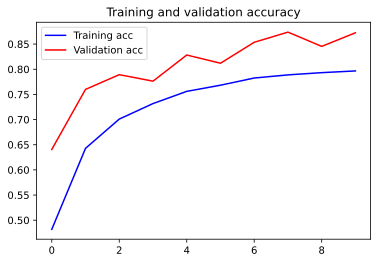

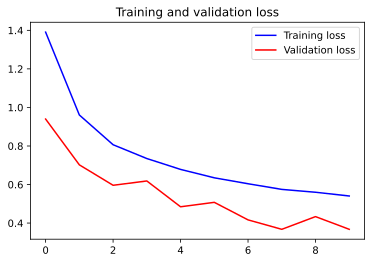

1/1 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5714
Accuracy before fit: 57.14%
Epoch 1/20
1891/1891 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.8485
Epoch 00001: val_accuracy improved from 0.87377 to 0.92572, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model7_1.hdf5
1891/1891 [==============================] - 1530s 809ms/step - loss: 0.4370 - accuracy: 0.8485 - val_loss: 0.2046 - val_accuracy: 0.9257
Epoch 2/20
1891/1891 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9203
Epoch 00002: val_accuracy improved from 0.92572 to 0.94118, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model7_1.hdf5
1891/1891 [==============================] - 1544s 816ms/step - loss: 0.2254 - accuracy: 0.9203 - val_loss: 0.1866 - val_accuracy: 0.9412
Epoch 3/20
1891/1891 [==============================] - ETA: 0s - loss: 0.1602 

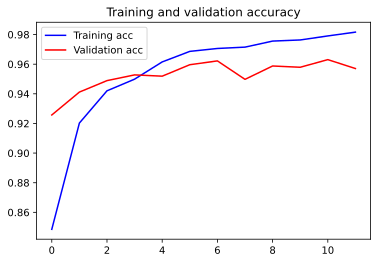

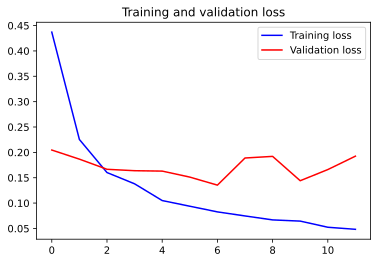

1/1 [==============================] - 0s 2ms/step - loss: 0.6282 - accuracy: 0.8571
Accuracy before fit: 85.71%
Epoch 1/20
1891/1891 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9875
Epoch 00001: val_accuracy improved from 0.96307 to 0.97123, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model7_1.hdf5
1891/1891 [==============================] - 1941s 1s/step - loss: 0.0322 - accuracy: 0.9875 - val_loss: 0.1407 - val_accuracy: 0.9712
Epoch 2/20
1891/1891 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9906
Epoch 00002: val_accuracy did not improve from 0.97123
1891/1891 [==============================] - 1929s 1s/step - loss: 0.0266 - accuracy: 0.9906 - val_loss: 0.1579 - val_accuracy: 0.9674
Epoch 3/20
1891/1891 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9933
Epoch 00003: val_accuracy did not improve from 0.97123
1891/1891 [==============================] - 

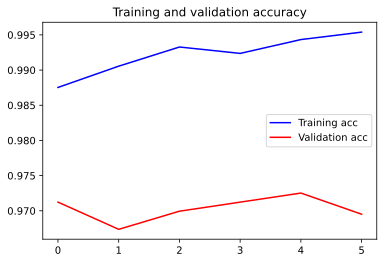

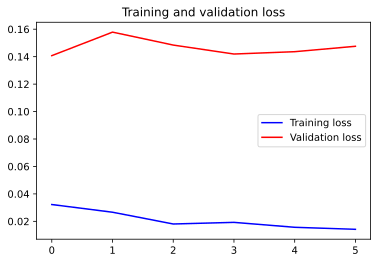

1/1 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.8571
Accuracy before fit: 85.71%
Epoch 1/20
1891/1891 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9951
Epoch 00001: val_accuracy did not improve from 0.97252
1891/1891 [==============================] - 2791s 1s/step - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.1475 - val_accuracy: 0.9717
Epoch 2/20
1891/1891 [==============================] - ETA: 0s - loss: 0.0129 - accuracy: 0.9959
Epoch 00002: val_accuracy did not improve from 0.97252
1891/1891 [==============================] - 2794s 1s/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.1466 - val_accuracy: 0.9704
Epoch 3/20
1891/1891 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9968
Epoch 00003: val_accuracy did not improve from 0.97252
1891/1891 [==============================] - 2789s 1s/step - loss: 0.0114 - accuracy: 0.9968 - val_loss: 0.1578 - val_accuracy: 0.9708
Epoch 4/20
1891/1891 [=

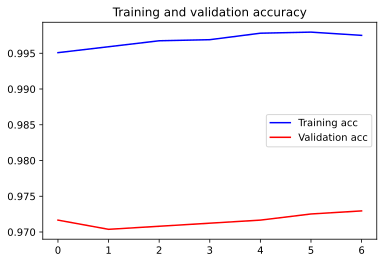

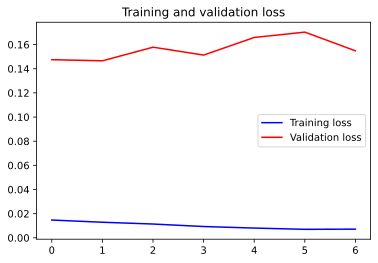

1/1 [==============================] - 0s 2ms/step - loss: 0.4343 - accuracy: 0.8571
Accuracy before fit: 85.71%
Epoch 1/20


ResourceExhaustedError: ignored

In [31]:
base_layers = len(base_model.layers)
# step 1 Обучаем только голову
config_model(False, l_r = 1e-3, ephochs = 10,   fine_tune_at = 0)

# step 2 Обучаем последний (7-ой) блок базовой модели
config_model(True, l_r = 1e-4, ephochs = 20,  fine_tune_at = 752)  

# step 3 Обучаем три последних(с 5-го) блока базовой модели
config_model(True, l_r = 1e-5, ephochs = 20,  fine_tune_at = 410)  

# step 4 Добавляем на обучение еще два (с 3-го) блока
config_model(True, l_r = 1e-5, ephochs = 20,  fine_tune_at = 157)  

# step 5 Обучаем всю модель
config_model(True, l_r = 6e-6, ephochs = 20 ,  fine_tune_at = 0)

Первый этап обучения дает хороший результат 83,37% . Сети EfficientNetB7 и Xception после первого этапа давали около 70% точности

На втором этапе результат еще выше 96,3 % 

Третий и Четвертый этапы дают небольшой прирост точности, до 97,29% 

На последнем этапе модель оказалась слишком большая , надо BATCH_SIZE сделать еще меньше. Но у нас сохранились веса лучшей итерации в обучении. Используем их в следующем ноутбуке Common.ipynb

А сейчас загрузим сохраненные веса, чтобы проверить чего мы достигли


In [ ]:
model.load_weights(os.path.join(DIR, f'best_model/best_model{ver}.hdf5'))

# Предсказание на тестовых данных

In [ ]:
# Test Time Augmentation (TTA)
from tqdm import tqdm

test_sub_generator.reset()
tta_steps = 10
l_predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    l_predictions.append(preds)

pred = np.mean(l_predictions, axis=0)

predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(DIR + f'submission/submission_{ver}.csv', index=False)
print('Save submit')

Но даже эта обученная модель дает отличный результат на kaggle - 0.97348